![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1
from sklearn import metrics

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train)

# Predicciones 
y_pred_dt = tree_predict(X_test, tree)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_dt))

Accuracy:  0.8599884526558892


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [6]:
# Celda 2
np.random.seed(12)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap
from sklearn.tree import DecisionTreeClassifier

# Definición del modelo usando DecisionTreeRegressor de sklearn
treecla = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred_bag = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X = X_train.iloc[sample]
    y = y_train.iloc[sample]
    mcla = treecla.fit(X, y)
    y_pred_bag.iloc[:,i] = mcla.predict(X_test)
    #print('Árbol ', i, 'tiene un error: ', metrics.accuracy_score(y_pred_bag.iloc[:,i], y_test))


# Predicciones mayoritaria para cada observación del set de test
y_pred_bag = (y_pred_bag.sum(axis=1) >= (n_B / 2)).astype(np.int)

from sklearn import metrics
print('Accuracy: ', metrics.accuracy_score(y_pred_bag, y_test))

Accuracy:  0.8530600461893765


In [7]:
# Definición del modelo usando DecisionTreeRegressor de sklearn
treecla = DecisionTreeClassifier(max_depth=10, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred_bag = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X = X_train.iloc[sample]
    y = y_train.iloc[sample]
    mcla = treecla.fit(X, y)
    y_pred_bag.iloc[:,i] = mcla.predict(X_test)
    #print('Árbol ', i, 'tiene un error: ', metrics.accuracy_score(y_pred_bag.iloc[:,i], y_test))


# Predicciones mayoritaria para cada observación del set de test
y_pred_bag = (y_pred_bag.sum(axis=1) >= (n_B / 2)).astype(np.int)

from sklearn import metrics
print('Accuracy: ', metrics.accuracy_score(y_pred_bag, y_test))

Accuracy:  0.8807736720554272


El bagging, con metodologia de votacion mayoritaria, tiene un buen desempeño, al obtener un 85% de precision. Para obtener un mejor desempeño, se podria hacer una calibracion de los parametros, por ejemplo al declarar max_depth=10, se obtiene una preciison del 88%.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [8]:
# Celda 3
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo BaggingClassifier como estimador
from sklearn.ensemble import BaggingClassifier

max_fea = int(np.log(X_train.shape[1]))
bagclas = BaggingClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=10, max_features = max_fea,
                           bootstrap=True, oob_score=True, random_state=1)

bagclas.fit(X_train, y_train)
y_pred_bagclas = bagclas.predict(X_test)

# Cálculo del  Accuracy y F1-Score del modelo
print('Accuracy: ', metrics.accuracy_score(y_test,y_pred_bagclas))

Accuracy:  0.851039260969977


Usando la libreria de sklearn, al bagging, con metodologia de votacion mayoritaria y max_depth=10, tiene un buen desempeño, al obtener un 85% de precision.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [9]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

#Impresión de desempeño del modelo usando la función cross_val_score  
display(pd.Series(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')).describe())
print('Accuracy TEST: ', pd.Series(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')).mean())















clf = RandomForestClassifier(random_state=1, n_jobs=-1)
clf.fit(X_train,y_train)
y_predclf = clf.predict(X_test)

rf_sincali = metrics.accuracy_score(y_test, y_predclf)
print('Accuracy TRAIN: ', rf_sincali)

count    10.000000
mean      0.836444
std       0.019918
min       0.796875
25%       0.829303
50%       0.836415
75%       0.842105
max       0.871977
dtype: float64

Accuracy TEST:  0.8360171101125047
Accuracy TRAIN:  0.8429561200923787


Se observa un buen ajuste del modelo, una mejoria en la presicion entre la muestra de entrenamiento y la de prueba. Sin embargo, se ve un menor desempeño respecto a los modelos de bagging ajustados en los puntos anteriores. 

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

(0.8506659769817665, 271)

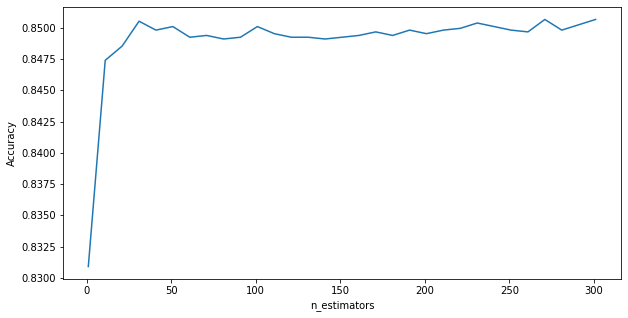

In [10]:
# Celda 5

###### Calibracion de n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(1, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, max_features=None, max_depth=None, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.figure(figsize=(10,5))
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente numero de estiamdosres
acc_opt_n_estimators, opt_n_estimators = sorted(zip(accuracy_scores, estimator_range))[::-1][0]
acc_opt_n_estimators, opt_n_estimators

In [11]:
clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=None, max_depth=None, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_n_estimators = metrics.accuracy_score(y_test, y_pred)
print(acc_n_estimators)

0.8539260969976905


(0.8506659769817665, 9)

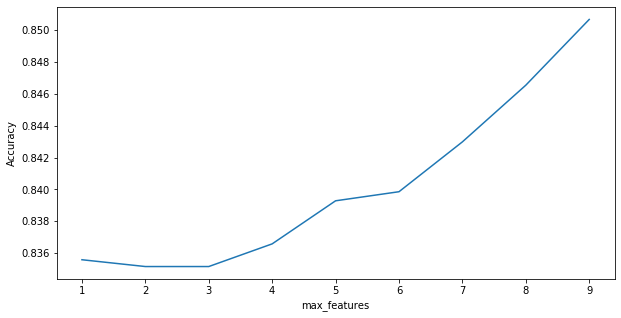

In [12]:
###### Calibracion de max_features
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    #clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=feature, random_state=1, n_jobs=-1)
    clf = RandomForestClassifier(max_features=feature, n_estimators=opt_n_estimators, max_depth=None, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.figure(figsize=(10,5))
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente numero de features
acc_opt_n_features, opt_n_features = sorted(zip(accuracy_scores, feature_range))[::-1][0]
acc_opt_n_features, opt_n_features

In [13]:
clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=opt_n_features, max_depth=None, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_opt_n_features = metrics.accuracy_score(y_test, y_pred)
acc_opt_n_features

0.8539260969976905

(0.8815284333376437, 7)

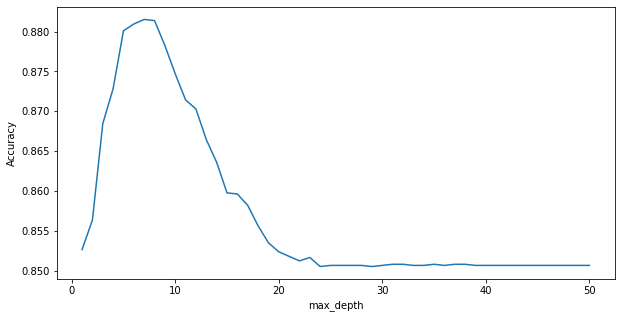

In [14]:
###### Calibracion de max_depth
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 51)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    #clf = RandomForestClassifier(max_features=opt_n_features, n_estimators=opt_n_estimators, max_depth=depth, random_state=1, n_jobs=-1)
    clf = RandomForestClassifier(max_features=None, n_estimators=opt_n_estimators, max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica el desempeño del modelo vs max_depth
plt.figure(figsize=(10,5))
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
acc_opt_max_depth, opt_max_depth = sorted(zip(accuracy_scores, max_depth_range))[::-1][0]
acc_opt_max_depth, opt_max_depth

In [15]:
clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=None, max_depth=opt_max_depth, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_opt_max_depth = metrics.accuracy_score(y_test, y_pred)
acc_opt_max_depth

0.8839491916859122

In [16]:
clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=opt_n_features, max_depth=opt_max_depth, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_tr = clf.predict(X_train)
y_pred = clf.predict(X_test)

metrics.accuracy_score(y_train, y_pred_tr), metrics.accuracy_score(y_test, y_pred)

(0.897880813540037, 0.8839491916859122)

In [17]:
clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=3, max_depth=opt_max_depth, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_tr = clf.predict(X_train)
y_pred = clf.predict(X_test)

rf_calibrado = metrics.accuracy_score(y_test, y_pred)

metrics.accuracy_score(y_train, y_pred_tr), metrics.accuracy_score(y_test, y_pred)

(0.8947518133978097, 0.8868360277136259)

Se obtinene que para los parametro calibrados se deberia ajustar un modelo con n_estimators = 271, max_features = 9 y max_depth = 7, para un modelo con un desempeño del 88% evaluado en la muestra de prueba. Sin embargo, se observa que al cambiar max_features por la raiz cuadrada del numero de variable predictoras, existe una mejoria en la precisión sobre la muestra de prueba.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [18]:
!pip install xgboost

In [19]:
# Celda 6
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
xgb = XGBClassifier(eval_metric = "error")
xgb

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test.values))

0.8856812933025404


Se observa un buen desempeño del modelo XGBoost, aun cuando no se hace una calibracion de los parametros, se obtiene una precision del 88.5%.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

(0.8822382564981248, 0.060000000000000005)

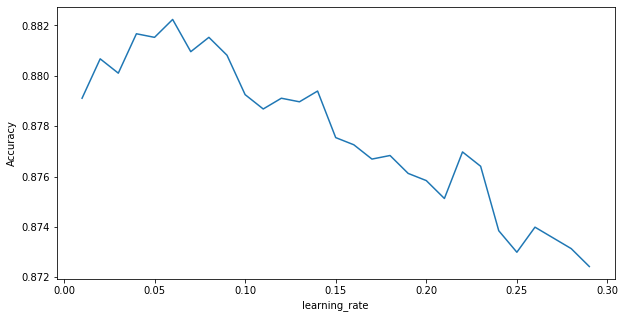

In [20]:
# Celda 7

### Calibracióm learning_rate (eta)
# Lista de valores para calibrar el criterio de Tasa de aprendizaje (Learning Rate)
learning_rate_range = np.arange(0.01, 0.3, 0.01)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de tasa de aprendizaje (Learning Rate)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la  tasa de aprendizaje
for learning_rate in learning_rate_range:
    clf = XGBClassifier(eval_metric = "error", eta=learning_rate)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica el desempeño del modelo vs learning_rate
plt.figure(figsize=(10,5))
plt.plot(learning_rate_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente learning_rate
acc_opt_learning_rate, opt_learning_rate = sorted(zip(accuracy_scores, learning_rate_range))[::-1][0]
acc_opt_learning_rate, opt_learning_rate

In [21]:
clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_opt_learning_rate = metrics.accuracy_score(y_test, y_pred)
acc_opt_learning_rate

0.8853926096997691

(0.884657272403983, 16.799999999999986)

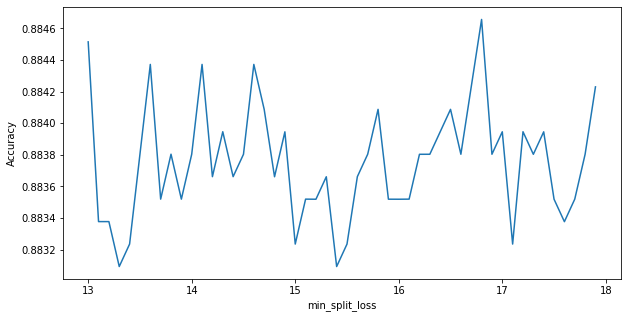

In [22]:
### Calibración min_split_loss (Gamma)

# Lista de valores para calibrar el criterio de Tasa de aprendizaje (Gamma)
min_split_loss_range = np.arange(13, 18, 0.1)
min_split_loss_range

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de min_split_loss
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la  tasa de aprendizaje
for min_split_loss in min_split_loss_range:
    clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate, gamma=min_split_loss)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica el desempeño del modelo vs learning_rate
plt.figure(figsize=(10,5))
plt.plot(min_split_loss_range, accuracy_scores)
plt.xlabel('min_split_loss')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente learning_rate
acc_opt_min_split_loss, opt_min_split_loss = sorted(zip(accuracy_scores, min_split_loss_range))[::-1][0]
acc_opt_min_split_loss, opt_min_split_loss

In [23]:
clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate, gamma=opt_min_split_loss)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_opt_min_split_loss = metrics.accuracy_score(y_test, y_pred)
acc_opt_min_split_loss

0.8877020785219399

(0.884657272403983, 1.0)

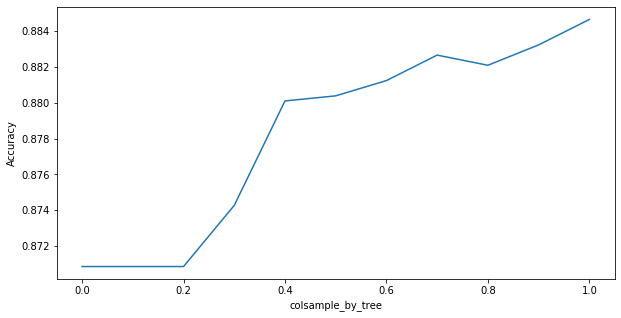

In [24]:
### Calibración colsample_bytree

# Lista de valores para calibrar el criterio de número de predictores considerados a en cada división (colsample_bytree)
colsample_by_tree_range = np.arange(0, 1.1, 0.1)
colsample_by_tree_range

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor del número de predictores considerados a en cada división.
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la  tasa de aprendizaje
for colsample_by_tree in colsample_by_tree_range:
    clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate, gamma=opt_min_split_loss, colsample_bytree=colsample_by_tree)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica el desempeño del modelo vs número de predictores considerados a en cada división.
plt.figure(figsize=(10,5))
plt.plot(colsample_by_tree_range, accuracy_scores)
plt.xlabel('colsample_by_tree')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente número de predictores considerados a en cada división.
acc_opt_colsample_by_tree, opt_colsample_by_tree = sorted(zip(accuracy_scores, colsample_by_tree_range))[::-1][0]
acc_opt_colsample_by_tree, opt_colsample_by_tree

In [25]:
clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate, gamma=opt_min_split_loss, colsample_bytree=opt_colsample_by_tree)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_opt_colsample_by_tree = metrics.accuracy_score(y_test, y_pred)
acc_opt_colsample_by_tree

0.8877020785219399

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

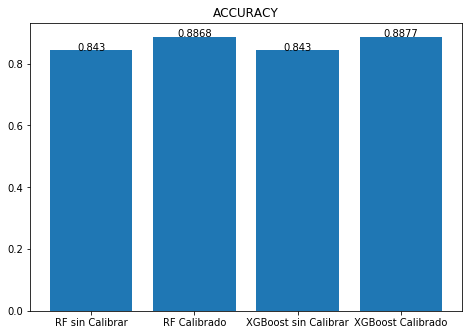

In [26]:
# Celda 8

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("ACCURACY")
XGBoost=0.8856812933025404
XGBoost_Calibrado=0.8862586605080831
ejeX = ['RF sin Calibrar', 'RF Calibrado', 'XGBoost sin Calibrar','XGBoost Calibrado']
ejeY = [ rf_sincali,  rf_calibrado, rf_sincali, acc_opt_colsample_by_tree]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,round(y[i], 4), round(y[i], 4), ha="center")
addlabels(ejeX,ejeY,plt)
plt.show()

Al comprar el Accuracy de los modelos realizados observamos que el modelo XGBoost Calibrado es el que mejor Accuracy presenta con un 88.77% superando todos los modelos construidos en este ejercicio, sin embargo al comparar el mejor modelo de XGBoost con el Random Forest Calibrado es posible entrar en la discusion si el ajuste ganado por XGBoost compensa el mayor esfuerzo computacional con respecto al Random Forest.

Sin duda la discusion sobre cual es el mejor modelo para mi problema dependera sobre el peso que le damos a un mejor nivel de ajuste vs un mayor costo en tiempo y recursos. 